# Maps without bridge and arena, hd histo without bridge and arena, for open field, light and dark trials




In [33]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 44 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 44/44 [00:10<00:00,  4.37it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


## Maps filtered on mouse direction

This can be used to estimate how directional are the firing field of a neuron in different conditions.

In [145]:
def getDirMaps(ses,sSes,interName="circ80",direction=np.pi/2, directionRange=np.pi/4, onlyArena=False):
    """
    Get all the maps of the data within the intervals of interest
    """
   
    xy_range=np.array([[-50,-90],[50,60]])
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    # set values of ap.pose outside our selected HD range to np.nan 
    sSes.ap.invalid_outside_head_direction_range(loc = direction, sigma = directionRange)
    
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 3, smoothing=True,xy_range=xy_range)
    mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
    mapStack = np.stack(mapList, axis=0)
    return mapStack

In [146]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[41]
ses = myProject.sessionList[41]
res = getDirMaps(ses,sSes,interName="circ80",direction=np.pi/2,directionRange=np.pi/4,onlyArena=True)
res.shape

(71, 33, 49)

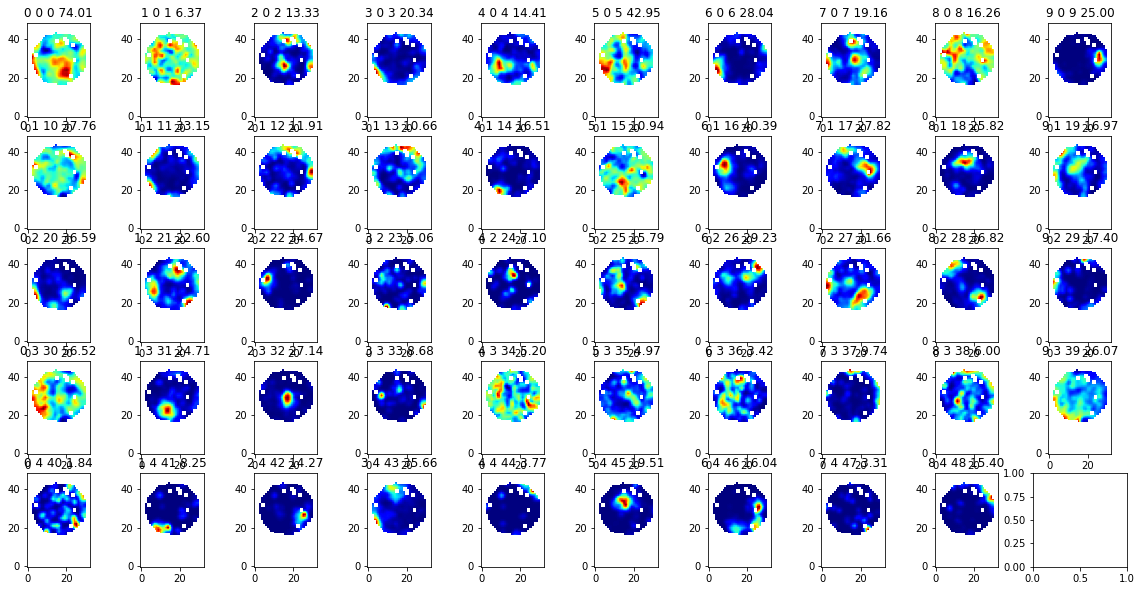

In [147]:
xSize=10
ySize=5
offset=0
fig,axis = plt.subplots(ySize,xSize,figsize=(xSize*2,ySize*2))
for i in range(res.shape[2]):
    x=i%xSize
    y=int(i/xSize)

    axis[y,x].imshow(res[i,:,:].T,cmap='jet',origin='lower')
    axis[y,x].set_title("{} {} {} {:.2f}".format(x,y,i,np.nanmax(res[i,:,:])))

In [148]:
conditions = ["circ80","circ80","light","light","dark","dark"]
onlyArenas = [False,False,True,True,True,True]
directions = [np.pi/2,-np.pi/2]*3
keys = ["circ80_north","circ80_south","light_north", "light_south","dark_north","dark_south"]

list(zip(conditions,onlyArenas,directions,keys))

[('circ80', False, 1.5707963267948966, 'circ80_north'),
 ('circ80', False, -1.5707963267948966, 'circ80_south'),
 ('light', True, 1.5707963267948966, 'light_north'),
 ('light', True, -1.5707963267948966, 'light_south'),
 ('dark', True, 1.5707963267948966, 'dark_north'),
 ('dark', True, -1.5707963267948966, 'dark_south')]

In [149]:
myDirMaps = {}
for key,cond,onlyArena,direction in zip(keys,conditions,onlyArenas,directions):
    print(key,cond,onlyArena,direction)
    myDirMaps[key] = np.concatenate([getDirMaps(ses,sSes,interName=cond,direction=direction,directionRange=np.pi/4,onlyArena=onlyArena) for ses, sSes  in zip(myProject.sessionList,sSesList)])

circ80_north circ80 False 1.5707963267948966
circ80_south circ80 False -1.5707963267948966
light_north light True 1.5707963267948966
light_south light True -1.5707963267948966
dark_north dark True 1.5707963267948966
dark_south dark True -1.5707963267948966


In [150]:
print(myDirMaps.keys())
[myDirMaps[k].shape for k in myDirMaps]

dict_keys(['circ80_north', 'circ80_south', 'light_north', 'light_south', 'dark_north', 'dark_south'])


[(1489, 33, 49),
 (1489, 33, 49),
 (1489, 33, 49),
 (1489, 33, 49),
 (1489, 33, 49),
 (1489, 33, 49)]

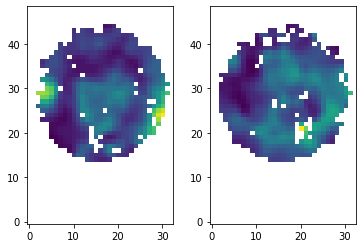

In [151]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(myDirMaps["circ80_north"][0,:,:].T,origin="lower")
ax[1].imshow(myDirMaps["circ80_south"][0,:,:].T,origin="lower")

In [152]:
fn=myProject.dataPath+"/results/myDirMaps.pickle"
print("Saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myDirMaps, handle)

Saving: /adata/projects/autopi_ca1/results/myDirMaps.pickle


Corrrelation between maps in different directions.

In [153]:
from scipy.stats import pearsonr
def map_cor(a,b):
    """
    Correlation coefficient between two firing rate maps
    
    Arguments:
    a: 2D np.array (map1)
    b: 2D np.array (map2)
    
    Returns:
    Pearson correlation coefficient between a and b
    """
    a = a.flatten()
    b = b.flatten()
    indices = np.logical_and(~np.isnan(a), ~np.isnan(b))
    if np.sum(indices)<2:
        return np.nan
    r,p = pearsonr(a[indices],b[indices])
    return r

In [154]:
env1 = ["circ80_north","light_north","dark_north"]
env2 = ["circ80_south","light_south","dark_south"]
condNames = ["circ80","light","dark"]
list(zip(env1,env2,condNames))

[('circ80_north', 'circ80_south', 'circ80'),
 ('light_north', 'light_south', 'light'),
 ('dark_north', 'dark_south', 'dark')]

In [155]:
dirMapCorDf = pd.DataFrame()
nCells=myDirMaps["circ80_north"].shape[0]
for e1,e2,c in zip(env1,env2,condNames):
    print(e1,e2,c)
    correlation  = [ map_cor(myDirMaps[e1][i],myDirMaps[e2][i]) for i in range(nCells) ]
    df1 = pd.DataFrame({"condition":c,
                       "r":correlation})
    dirMapCorDf = pd.concat([dirMapCorDf,df1])

circ80_north circ80_south circ80
light_north light_south light
dark_north dark_south dark


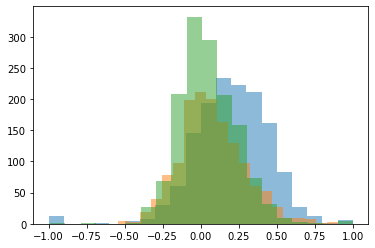

In [160]:
plt.hist(dirMapCorDf[dirMapCorDf.condition=="circ80"].r,alpha=0.5,bins=20)
plt.hist(dirMapCorDf[dirMapCorDf.condition=="light"].r,alpha=0.5,bins=20)
plt.hist(dirMapCorDf[dirMapCorDf.condition=="dark"].r,alpha=0.5,bins=20)
plt.show()

In [162]:
fn=myProject.dataPath+"/results/dirMapCorDf.csv"
print("Saving to",fn)
dirMapCorDf.to_csv(fn,index=False)

Saving to /adata/projects/autopi_ca1/results/dirMapCorDf.csv


# Head direction histograms with and without bridge+arena

We want to do an analysis similar to the friring rate maps but for head-direction firing rate histograms. 

In [3]:
def getHdHisto(ses,sSes,interName="circ80",onlyArena=False):
    """
    Get all the hd histo of the data within the intervals of interest
    """
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True)
        
    histoList = [ n.spatial_properties.firing_rate_head_direction_histo for n in sSes.cg.neuron_list ]
    histoStack = np.stack(histoList, axis=0)
    return histoStack

In [4]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[41]
ses = myProject.sessionList[41]
res = getHdHisto(ses,sSes,interName="dark",onlyArena=True)

/tmp/ipykernel_117197/3789952760.py:9: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[r,c].set_ylim(0,np.nanmax(res[i]))
/tmp/ipykernel_117197/3789952760.py:9: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[r,c].set_ylim(0,np.nanmax(res[i]))


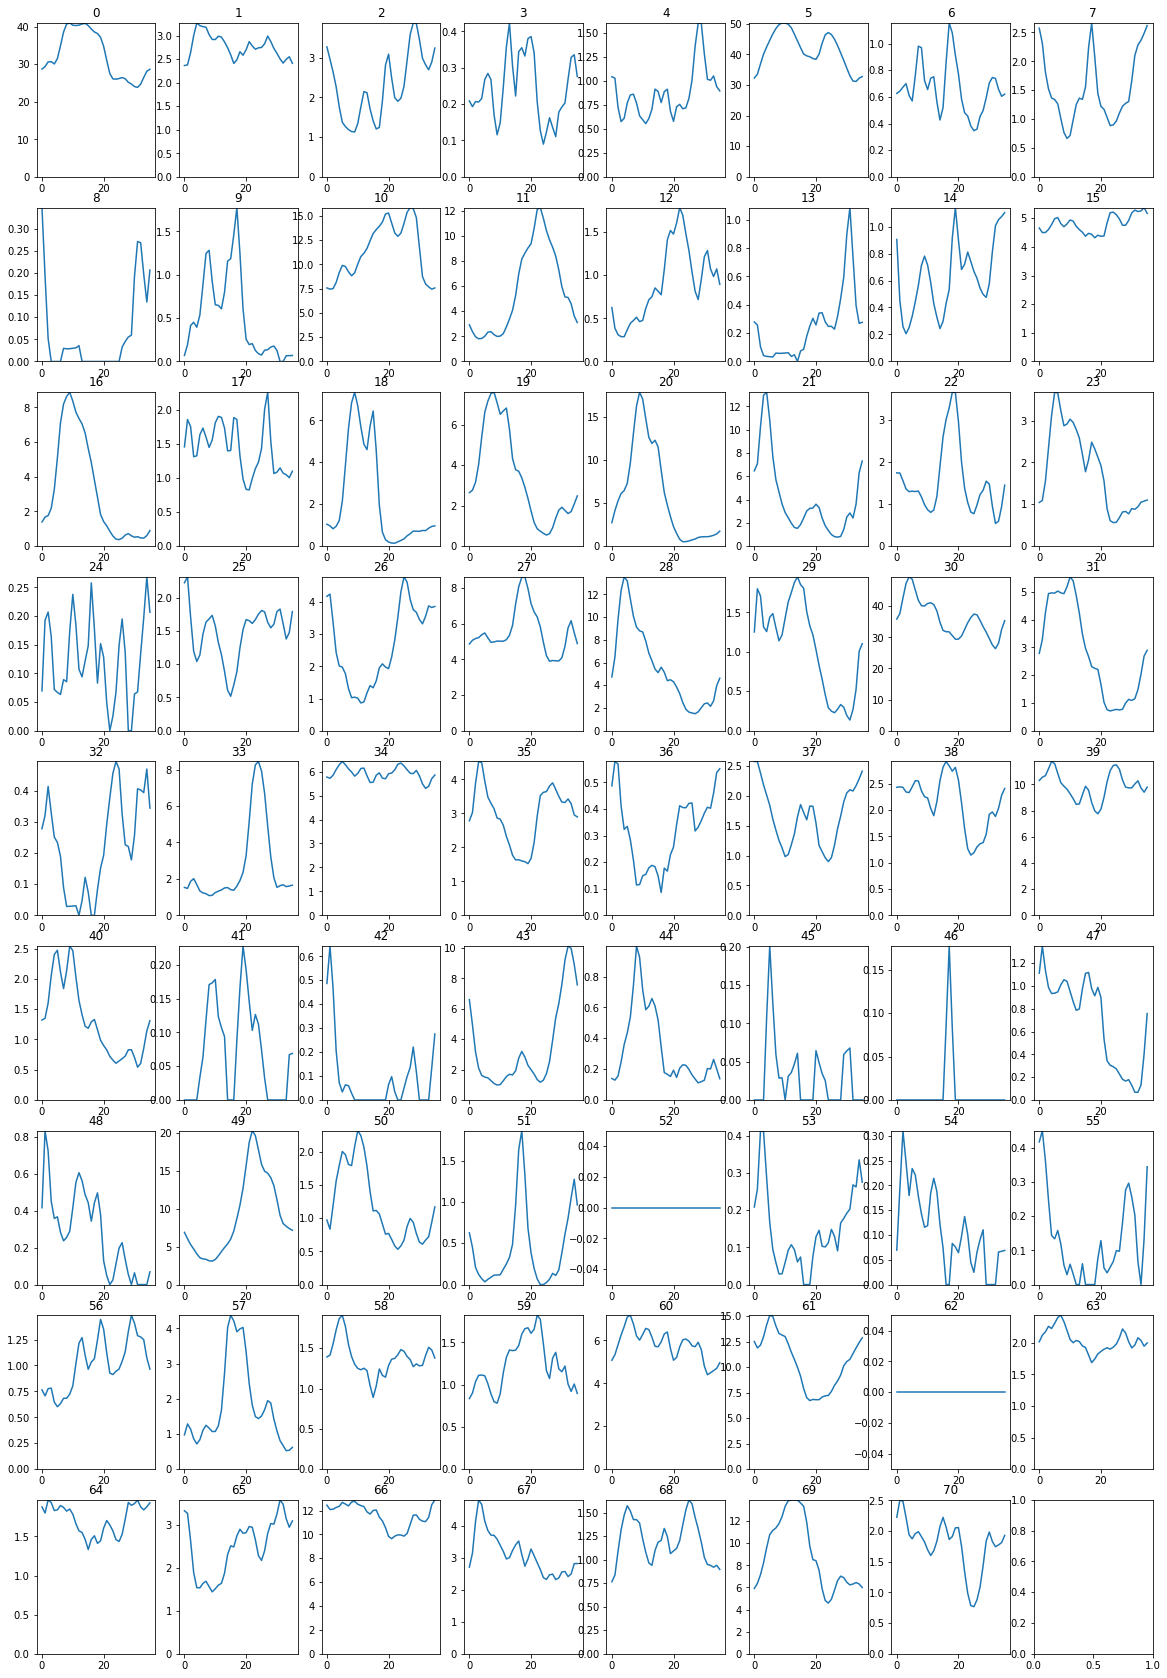

In [5]:
ncol=8
nrow=9
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))
for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(res[i])
    ax[r,c].set_title(i)
    ax[r,c].set_ylim(0,np.nanmax(res[i]))

In [6]:
conditions = ["circ80","circ80_1","circ80_2","light","light","dark","dark"]
onlyArena = [False,False,False,False,True,False,True]
keys = ["circ80","circ80_1","circ80_2","light","light_arena","dark","dark_arena"]
print(list(zip(keys,conditions,onlyArena)))

[('circ80', 'circ80', False), ('circ80_1', 'circ80_1', False), ('circ80_2', 'circ80_2', False), ('light', 'light', False), ('light_arena', 'light', True), ('dark', 'dark', False), ('dark_arena', 'dark', True)]


In [7]:
myHdHist = {}
for key,cond,onlyA in zip(keys,conditions,onlyArena):
    print(key,cond,onlyA)
    myHdHist[key] = np.concatenate([getHdHisto(ses,sSes,cond,onlyA) for ses,sSes in zip(myProject.sessionList,sSesList)])

circ80 circ80 False
circ80_1 circ80_1 False
circ80_2 circ80_2 False
light light False
light_arena light True
dark dark False
dark_arena dark True


Check for sanity

In [8]:
print(myHdHist.keys())
[myHdHist[k].shape for k in myHdHist]

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'light', 'light_arena', 'dark', 'dark_arena'])


[(1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36)]

(80, 36)


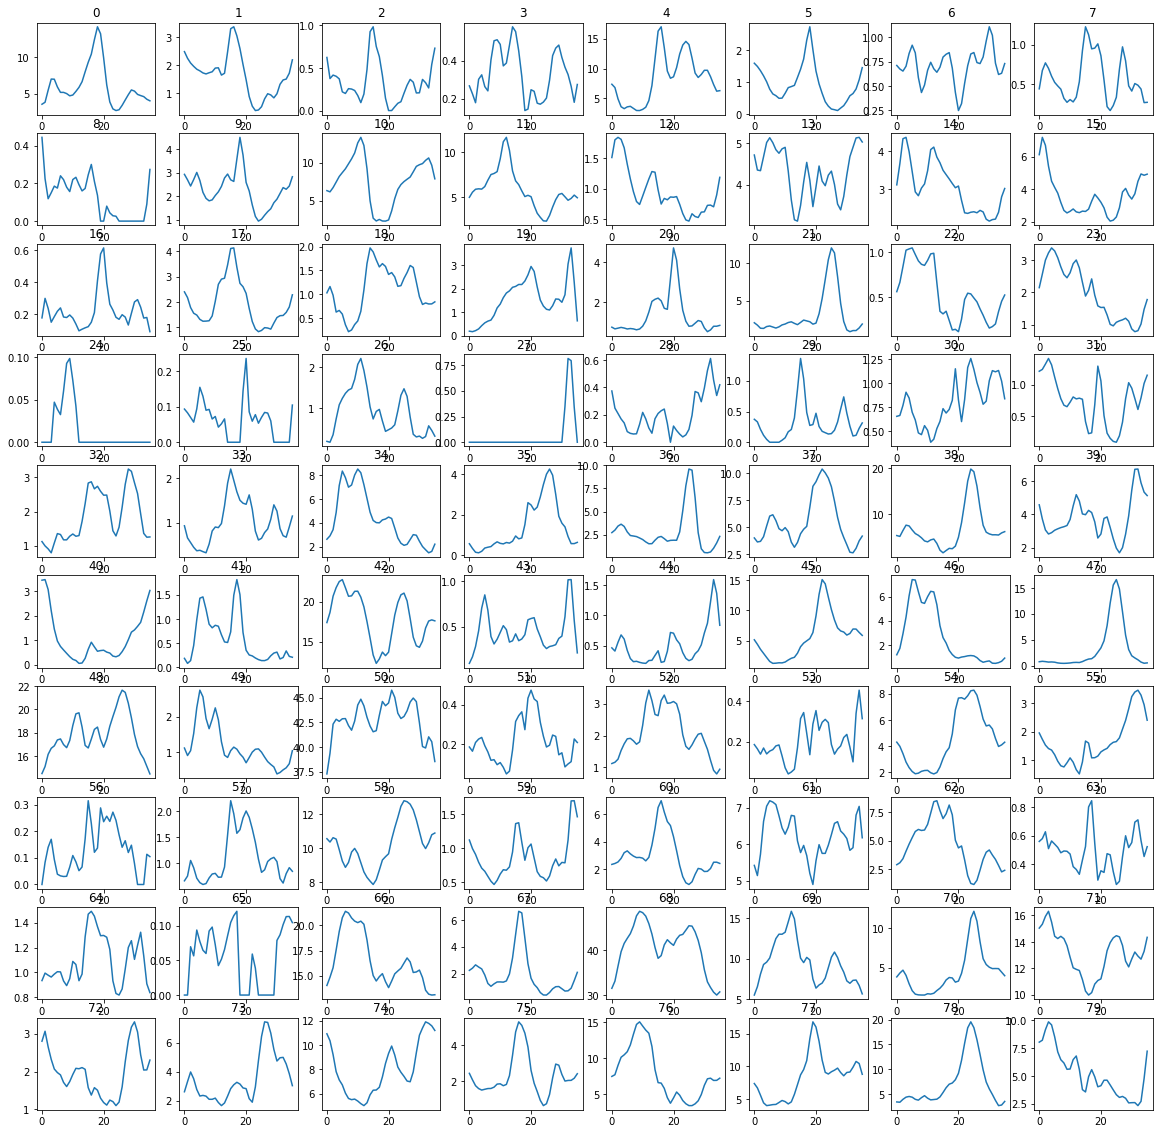

In [9]:
res= myHdHist["dark_arena"][-80:,:]
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,20))

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(res[i])
    ax[r,c].set_title(i)

Save the dictionary as a pickle object.

In [10]:
fn=myProject.dataPath+"/results/myHdHist.pickle"
with open(fn, 'wb') as handle:
    pickle.dump(myHdHist, handle)

# Head-direction statistics

We want to calculate the mean vector length and prefered direction for all these neurons.

We could create a data frame with 4 columns: cellId, condition, prefDir, vectorLenght


In [22]:
def getHdStats(ses,sSes,interName="circ80",onlyArena=False, conditionName="x"):
    """
    Get all the preferred direction and vector length
    """
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        # create the histogram
        n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True)
        n.spatial_properties.head_direction_score() 
      
    # separate the variables
    cellId = [sSes.name+"_"+ n.name for n in sSes.cg.neuron_list]
    prefDir =[n.spatial_properties.hd_mean_direction_rad for n in sSes.cg.neuron_list]
    peakAngle = [n.spatial_properties.hd_peak_angle_rad for n in sSes.cg.neuron_list]
    peakRate = [n.spatial_properties.hd_peak_rate for n in sSes.cg.neuron_list]
    vectorLength =  [n.spatial_properties.hd_mean_vector_length for n in sSes.cg.neuron_list]
    
    df = pd.DataFrame({"cellId":cellId,
                       "condition":conditionName,
                      "prefDir":prefDir,
                       "peakAngle":peakAngle,
                       "peakRate":peakRate,
                      "vectorLength":vectorLength})
    
    return df

We will run this on one session and make sure our stats are in agreement with our hd rate histograms.

In [23]:
sSes = sSesList[41]
ses = myProject.sessionList[41]
df = getHdStats(ses,sSes,interName="dark",onlyArena=True,conditionName="dark")
res = getHdHisto(ses,sSes,interName="dark",onlyArena=True)

In [24]:
df

,cellId,condition,prefDir,peakAngle,peakRate,vectorLength
0,mn9686-28102021-0107_0,dark,-0.953715,-1.483530,41.003372,0.130276
1,mn9686-28102021-0107_9,dark,-1.442612,-2.356194,3.268295,0.027192
2,mn9686-28102021-0107_10,dark,2.101655,1.832596,3.869495,0.203478
3,mn9686-28102021-0107_11,dark,-0.715210,-0.785398,0.422924,0.102915
4,mn9686-28102021-0107_12,dark,2.117505,1.832596,1.603076,0.135091
...,...,...,...,...,...,...
66,mn9686-28102021-0107_268,dark,-2.087984,3.054326,12.886483,0.054558
67,mn9686-28102021-0107_270,dark,-1.721427,-2.530727,4.812500,0.112208
68,mn9686-28102021-0107_295,dark,0.014778,1.308997,1.634170,0.028857
69,mn9686-28102021-0107_297,dark,-1.063317,-0.785398,13.909494,0.228450


(71, 36)


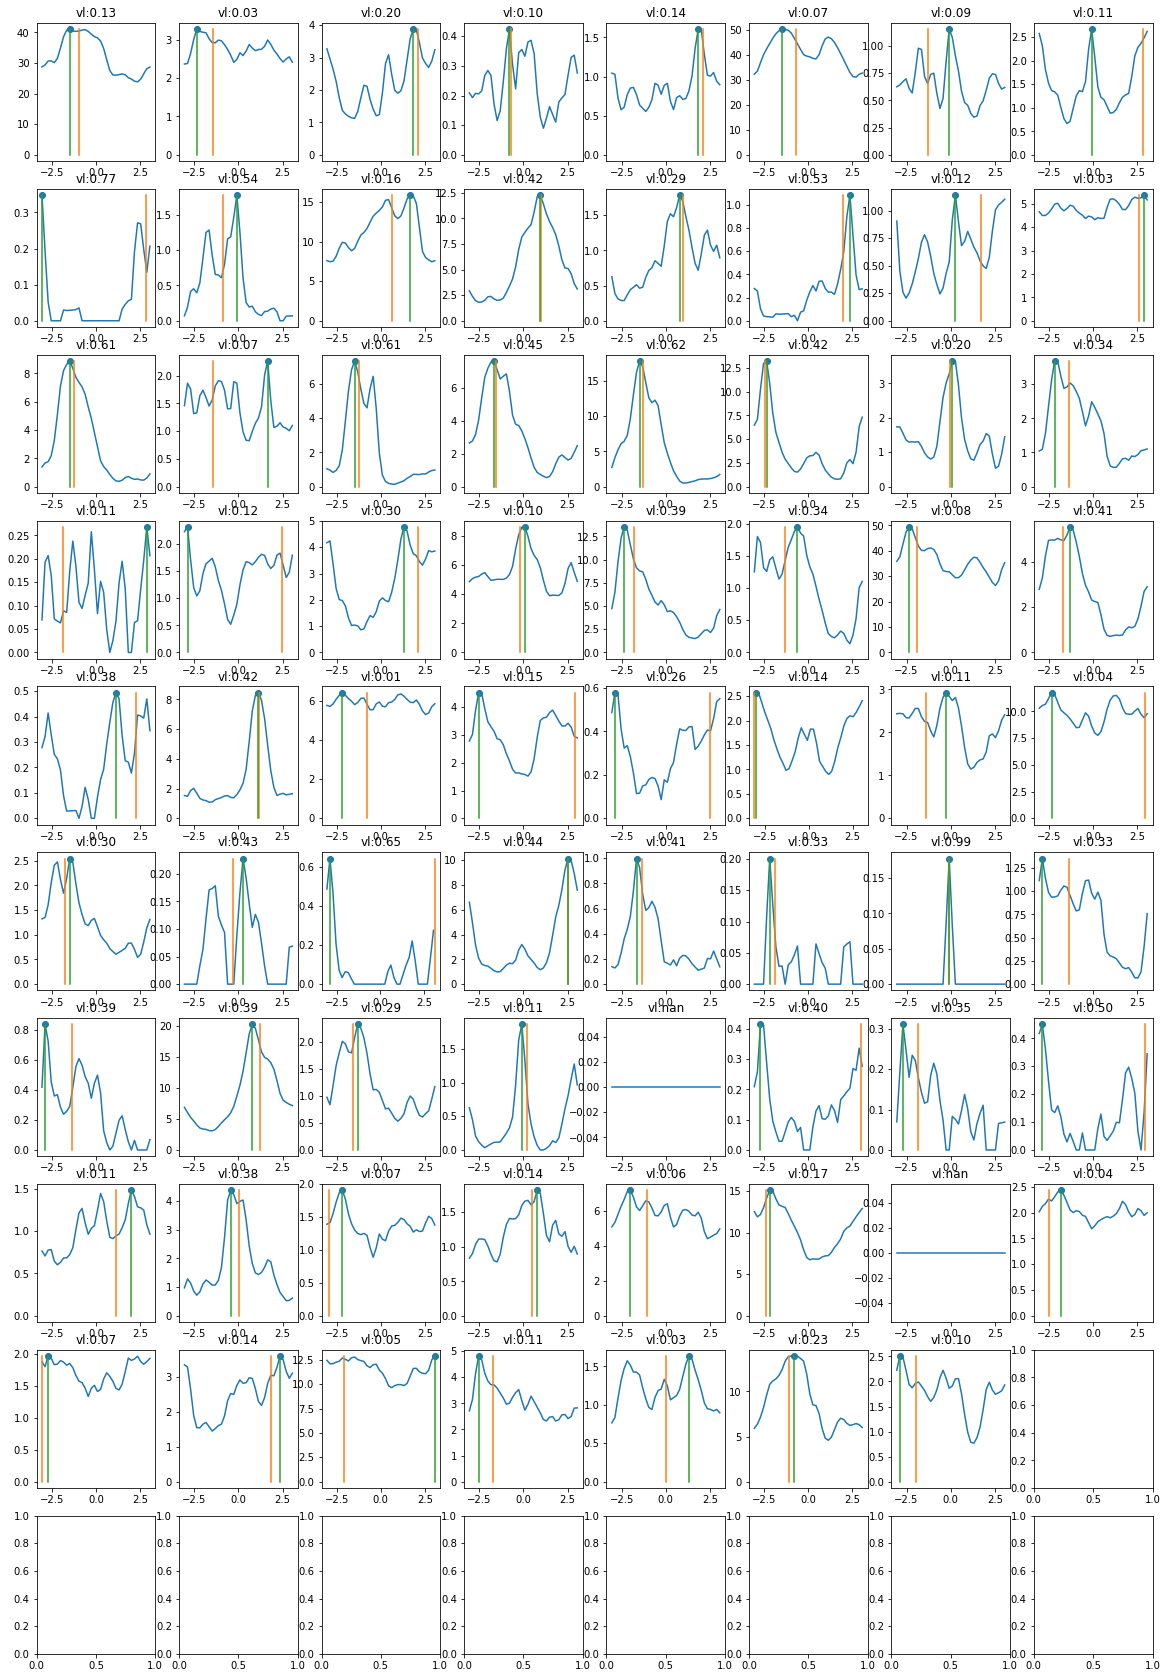

In [25]:
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))
angles = sSes.cg.neuron_list[0].spatial_properties.firing_rate_head_direction_mid_angles

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(angles, res[i])
    ax[r,c].plot([df.prefDir.iloc[i],df.prefDir.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].plot([df.peakAngle.iloc[i],df.peakAngle.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].scatter(df.peakAngle.iloc[i],df.peakRate.iloc[i])
    ax[r,c].set_title("vl:{:.2f}".format(df.vectorLength.iloc[i]))

Now we can apply our function to all our conditions.

We can get a single data frame with all our conditions.

In [26]:
conditions = ["circ80","circ80_1","circ80_2","light","light","dark","dark"]
onlyArena = [False,False,False,False,True,False,True]
keys = ["circ80","circ80_1","circ80_2","light","light_arena","dark","dark_arena"]
print(list(zip(keys,conditions,onlyArena)))

[('circ80', 'circ80', False), ('circ80_1', 'circ80_1', False), ('circ80_2', 'circ80_2', False), ('light', 'light', False), ('light_arena', 'light', True), ('dark', 'dark', False), ('dark_arena', 'dark', True)]


In [27]:
dfHdStats=pd.DataFrame()
for key,cond,onlyA in zip(keys,conditions,onlyArena):
    print(key,cond,onlyA)
    condDf = pd.concat([getHdStats(ses,sSes,cond,onlyA,key) for ses,sSes in zip(myProject.sessionList,sSesList)])
    dfHdStats = pd.concat([dfHdStats,condDf])

circ80 circ80 False
circ80_1 circ80_1 False
circ80_2 circ80_2 False
light light False
light_arena light True
dark dark False
dark_arena dark True


In [28]:
fn=fn=myProject.dataPath+"/results/myHdStats.csv"
print(fn)
dfHdStats.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/myHdStats.csv


Sanity check on the data

In [29]:
df_sel = dfHdStats[dfHdStats.condition=="dark_arena"].iloc[-80:,:]

(80, 36)


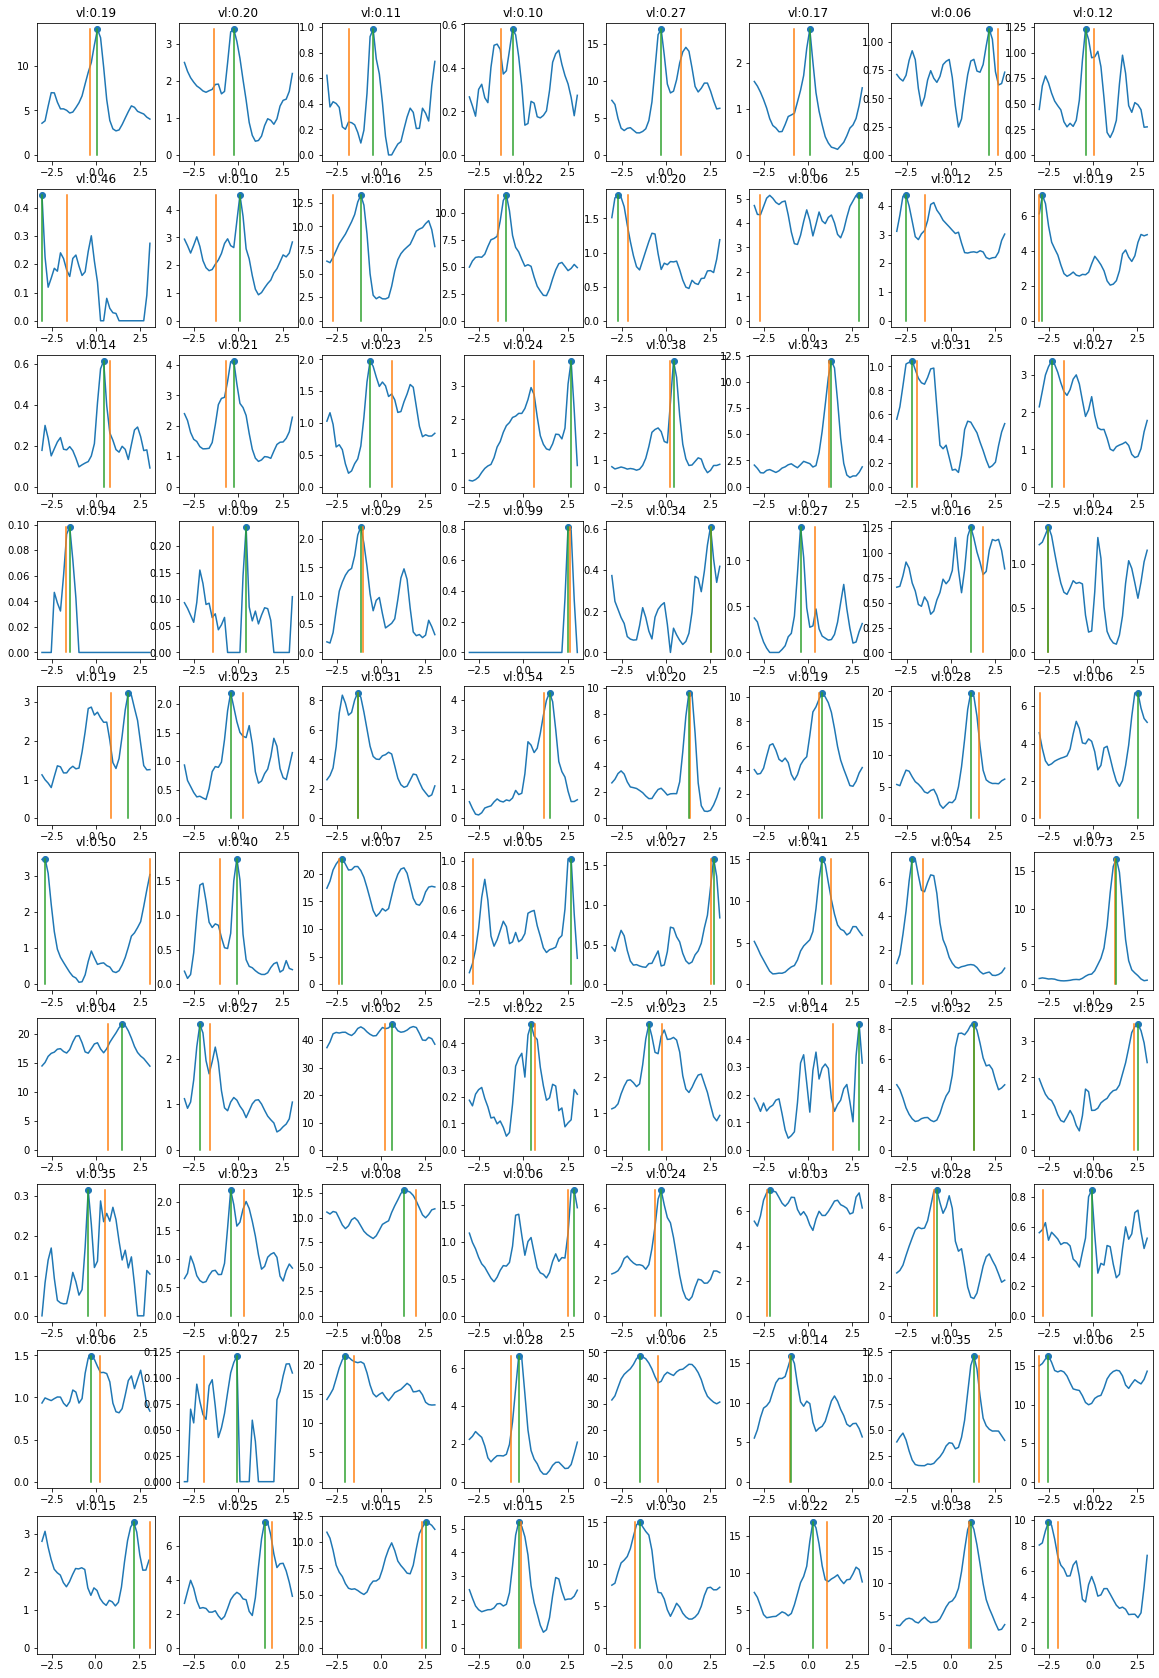

In [30]:
res= myHdHist["dark_arena"][-80:,:]
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(angles, res[i])
    ax[r,c].plot([df_sel.prefDir.iloc[i],df_sel.prefDir.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].plot([df_sel.peakAngle.iloc[i],df_sel.peakAngle.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].scatter(df_sel.peakAngle.iloc[i],df_sel.peakRate.iloc[i])
    ax[r,c].set_title("vl:{:.2f}".format(df_sel.vectorLength.iloc[i]))

## HD histogram stability across conditions

Correlate HD histograms of the same neurons across conditions.

We save the data in a DataFrame with condition and r values. The order of the data should be the same as for the tuning curves.


In [42]:
from scipy.stats import pearsonr
def map_cor(a,b):
    """
    Correlation coefficient between two firing rate maps
    
    Arguments:
    a: 2D np.array (map1)
    b: 2D np.array (map2)
    
    Returns:
    Pearson correlation coefficient between a and b
    """
    a = a.flatten()
    b = b.flatten()
    indices = np.logical_and(~np.isnan(a), ~np.isnan(b))
    if np.sum(indices)<2:
        return np.nan
    r,p = pearsonr(a[indices],b[indices])
    return r

In [43]:
myHdHist.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'light', 'light_arena', 'dark', 'dark_arena'])

In [44]:
env1 = ["circ80_1","light_arena","circ80","circ80"]
env2 = ["circ80_2","dark_arena","light_arena","dark_arena"]
condNames = ["oo","ld","ol","od"]
list(zip(env1,env2,condNames))

[('circ80_1', 'circ80_2', 'oo'),
 ('light_arena', 'dark_arena', 'ld'),
 ('circ80', 'light_arena', 'ol'),
 ('circ80', 'dark_arena', 'od')]

In [45]:
hdCorDf = pd.DataFrame()
nCells=myHdHist["circ80"].shape[0]
for e1,e2,c in zip(env1,env2,condNames):
    print(e1,e2,c)
    print(myHdHist[e1][i].shape,myHdHist[e2][i].shape)
    correlation  = [ map_cor(myHdHist[e1][i],myHdHist[e2][i]) for i in range(nCells) ]
    df1 = pd.DataFrame({"condition":c,
                       "r":correlation})
    hdCorDf = pd.concat([hdCorDf,df1])

circ80_1 circ80_2 oo
(36,) (36,)
light_arena dark_arena ld
(36,) (36,)
circ80 light_arena ol
(36,) (36,)
circ80 dark_arena od
(36,) (36,)


In [46]:
fn=fn=myProject.dataPath+"/results/myHdStability.csv"
print(fn)
hdCorDf.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/myHdStability.csv


Sanity check with a few cells, light dark conditions

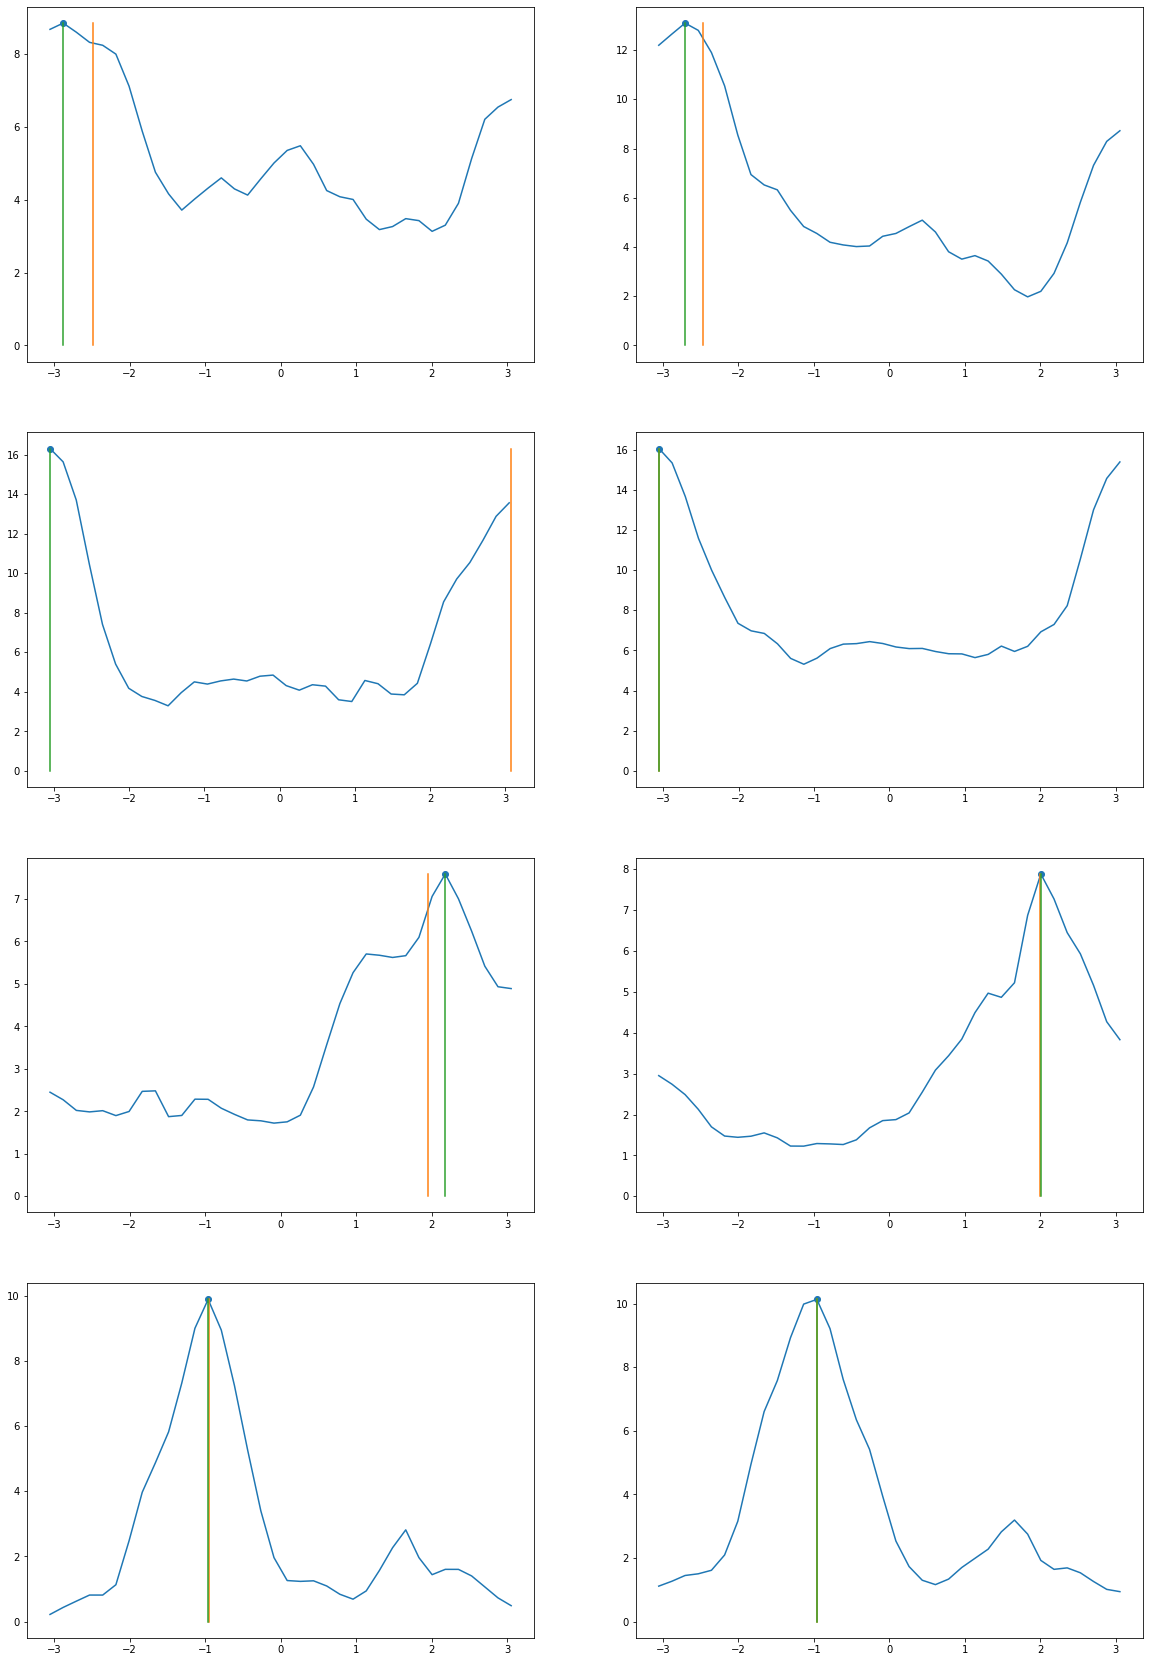

In [47]:
stableIndices= hdCorDf.r[hdCorDf.condition=="ld"] > 0.95  # < -0.6 or > 0.95 

cor = hdCorDf[hdCorDf.condition=="ld"][stableIndices]
statl = dfHdStats[dfHdStats.condition=="light_arena"][stableIndices.to_numpy()]
statd = dfHdStats[dfHdStats.condition=="dark_arena"][stableIndices.to_numpy()]
histl = myHdHist["light_arena"][stableIndices.to_numpy()]
histd = myHdHist["dark_arena"][stableIndices.to_numpy()]
    
ncol=2
nrow=histl.shape[0]
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))

for i in range(nrow):
    ax[i,0].plot(angles,histl[i])
    ax[i,0].plot([statl.prefDir.iloc[i],statl.prefDir.iloc[i]],[0,np.nanmax(histl[i])])
    ax[i,0].plot([statl.peakAngle.iloc[i],statl.peakAngle.iloc[i]],[0,np.nanmax(histl[i])])
    ax[i,0].scatter(statl.peakAngle.iloc[i],statl.peakRate.iloc[i])
    
    
    ax[i,1].plot(angles,histd[i])
    ax[i,1].plot([statd.prefDir.iloc[i],statd.prefDir.iloc[i]],[0,np.nanmax(histd[i])])
    ax[i,1].plot([statd.peakAngle.iloc[i],statd.peakAngle.iloc[i]],[0,np.nanmax(histd[i])])
    ax[i,1].scatter(statd.peakAngle.iloc[i],statd.peakRate.iloc[i])
    

## Head-direction significant threshold

In [2]:
def getHdThreshold(ses,sSes,interName="circ80",onlyArena=False, conditionName="x",iterations=100):
    """
    Get all the significance threshold for the vector length
    """
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        
        # get the threshold
        n.spatial_properties.shuffle_head_direction_score(iterations=iterations, deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True, percentile=95)

        
    # create a data frame
    cellId = [sSes.name+"_"+ n.name for n in sSes.cg.neuron_list]
    vlThreshold =  [n.spatial_properties.head_direction_score_threshold for n in sSes.cg.neuron_list]
    
    df = pd.DataFrame({"cellId":cellId,
                       "condition":conditionName,
                      "vlThreshold":vlThreshold})
    
    return df

In [6]:
%%time
sSes = sSesList[41]
ses = myProject.sessionList[41]
df = getHdThreshold(ses,sSes,interName="dark",onlyArena=True,conditionName="dark")
df

CPU times: user 1min 5s, sys: 208 ms, total: 1min 6s
Wall time: 1min 6s


,cellId,condition,vlThreshold
0,mn9686-28102021-0107_0,dark,0.028376
1,mn9686-28102021-0107_9,dark,0.055565
2,mn9686-28102021-0107_10,dark,0.078390
3,mn9686-28102021-0107_11,dark,0.173314
4,mn9686-28102021-0107_12,dark,0.098953
...,...,...,...
66,mn9686-28102021-0107_268,dark,0.038645
67,mn9686-28102021-0107_270,dark,0.065835
68,mn9686-28102021-0107_295,dark,0.064432
69,mn9686-28102021-0107_297,dark,0.080077


In [4]:
conditions = ["circ80","circ80_1","circ80_2","light","light","dark","dark"]
onlyArena = [False,False,False,False,True,False,True]
keys = ["circ80","circ80_1","circ80_2","light","light_arena","dark","dark_arena"]
print(list(zip(keys,conditions,onlyArena)))

[('circ80', 'circ80', False), ('circ80_1', 'circ80_1', False), ('circ80_2', 'circ80_2', False), ('light', 'light', False), ('light_arena', 'light', True), ('dark', 'dark', False), ('dark_arena', 'dark', True)]


In [5]:
dfHdThreshold=pd.DataFrame()
for key,cond,onlyA in zip(keys,conditions,onlyArena):
    print(key,cond,onlyA)
    condDf = pd.concat([getHdThreshold(ses,sSes,cond,onlyA,key,iterations=100) for ses,sSes in tqdm(zip(myProject.sessionList,sSesList))])
    dfHdThreshold = pd.concat([dfHdThreshold,condDf])

circ80 circ80 False


44it [26:23, 36.00s/it]


circ80_1 circ80_1 False


44it [11:39, 15.91s/it]


circ80_2 circ80_2 False


44it [11:33, 15.77s/it]


light light False


44it [20:48, 28.38s/it]


light_arena light True


44it [15:41, 21.41s/it]


dark dark False


44it [29:55, 40.80s/it]


dark_arena dark True


44it [24:12, 33.02s/it]


In [9]:
dfHdThreshold

,cellId,condition,vlThreshold
0,mn5824-20112020-0107_80,circ80,0.040487
1,mn5824-20112020-0107_90,circ80,0.042182
2,mn5824-20112020-0107_92,circ80,0.067604
3,mn5824-20112020-0107_96,circ80,NaN
4,mn5824-20112020-0107_98,circ80,0.047352
...,...,...,...
57,mn9686-01112021-0106_238,dark_arena,0.094176
58,mn9686-01112021-0106_240,dark_arena,0.082810
59,mn9686-01112021-0106_241,dark_arena,0.087917
60,mn9686-01112021-0106_242,dark_arena,0.088264


In [10]:
fn=fn=myProject.dataPath+"/results/myHdThreshold.csv"
print(fn)
dfHdThreshold.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/myHdThreshold.csv
